In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  
import seaborn as sns

%matplotlib inline

In [3]:
temp_df = pd.read_csv("/content/drive/MyDrive/Dogus Tech Interview/machine_temperature_system_failure.csv", parse_dates=True, index_col="timestamp")
print(temp_df.shape)

temp_df.head()

(22695, 1)


,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


In [5]:
temp_df.tail() # data is from 2013-12-02 21:15:00 to 2014-02-19 15:25:00 with 5 minutes resolution 

,value
timestamp,
2014-02-19 15:05:00,98.185415
2014-02-19 15:10:00,97.804168
2014-02-19 15:15:00,97.135468
2014-02-19 15:20:00,98.056852
2014-02-19 15:25:00,96.903861


In [4]:
temp_df.info() # no null data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22695 entries, 2013-12-02 21:15:00 to 2014-02-19 15:25:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   22695 non-null  float64
dtypes: float64(1)
memory usage: 354.6 KB


Text(0.5, 1.0, 'Machine Temperature')

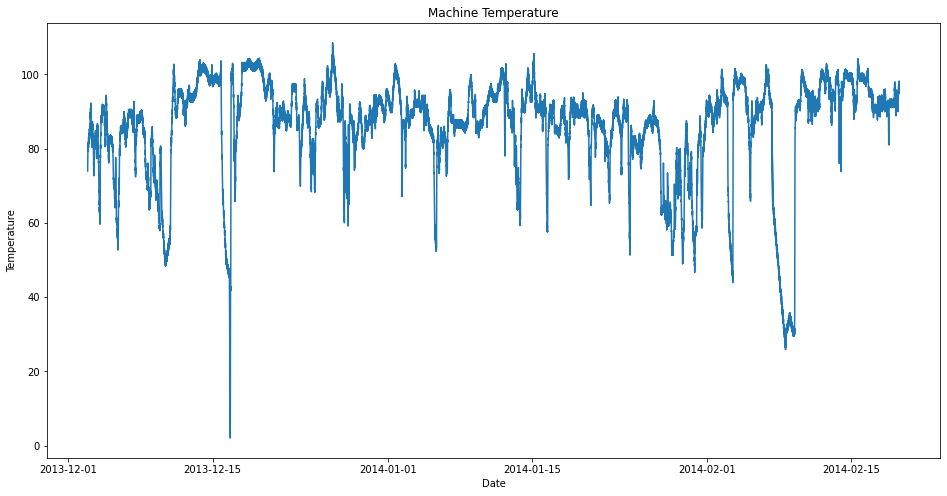

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(temp_df.value)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature")
ax.set_title("Machine Temperature")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


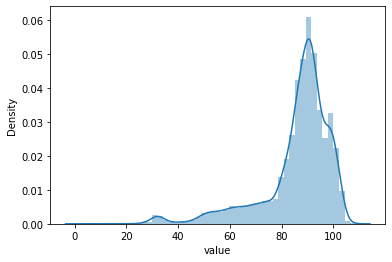

In [8]:
#histogram
sns.distplot(temp_df['value'])
# Maybe order_quantity values after (mean + 3*std) can be seen as outliers.
# But I will assume they are correct  since they can belong to the same part.
# We'll see this deduction in later.

In [9]:
temp_df['value'].describe()

count    22695.000000
mean        85.926498
std         13.746912
min          2.084721
25%         83.080078
50%         89.408246
75%         94.016252
max        108.510543
Name: value, dtype: float64

In [14]:
stat_temp = temp_df['value'].describe()
upper_bound = stat_temp["mean"] + 3*stat_temp["std"]
lower_bound = stat_temp["mean"] - 3*stat_temp["std"]
print(round(upper_bound, 2))
print(round(lower_bound, 2))

127.17
44.69


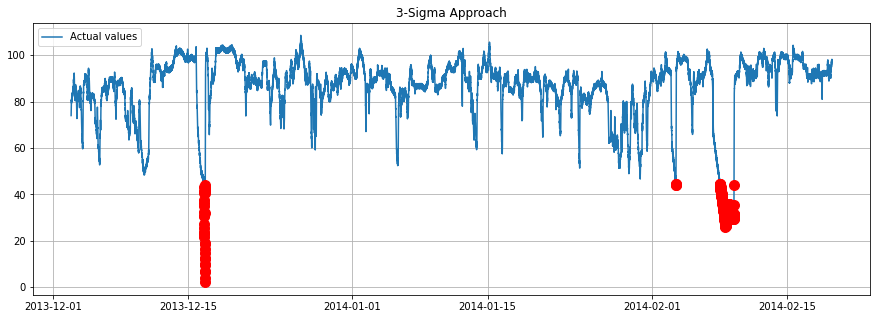

In [18]:
anomalies = pd.DataFrame(index=temp_df.index, columns=temp_df.columns)
anomalies[temp_df<lower_bound] = temp_df[temp_df<lower_bound]
anomalies[temp_df>upper_bound] = temp_df[temp_df>upper_bound]

plt.figure(figsize=(15,5))
plt.title("3-Sigma Approach")
plt.plot(temp_df, label="Actual values")
plt.legend(loc="upper left")
plt.grid(True)
plt.plot(anomalies, "ro", markersize=10)

In [27]:
a = anomalies.dropna()
print(a.head())
print(a.tail())

                       value
timestamp                   
2013-12-16 15:25:00  43.1775
2013-12-16 15:30:00   41.309
2013-12-16 15:35:00  40.4614
2013-12-16 15:40:00  37.7913
2013-12-16 15:45:00  36.2497
                       value
timestamp                   
2014-02-09 11:35:00  31.0862
2014-02-09 11:40:00  30.9389
2014-02-09 11:45:00  30.9755
2014-02-09 11:50:00  35.6241
2014-02-09 11:55:00  43.9713


In [19]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(temp_df, 24) # prediction for the last observed day (past 24 hours)

96.62159614166667

In [21]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

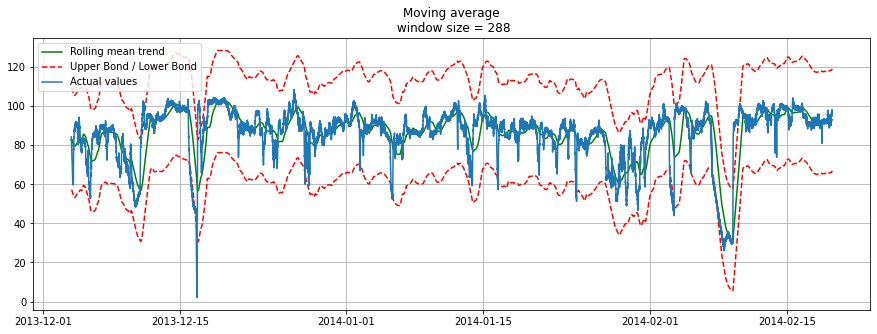

In [22]:
plotMovingAverage(temp_df, int(24*60/5), plot_intervals=True) # daily trend

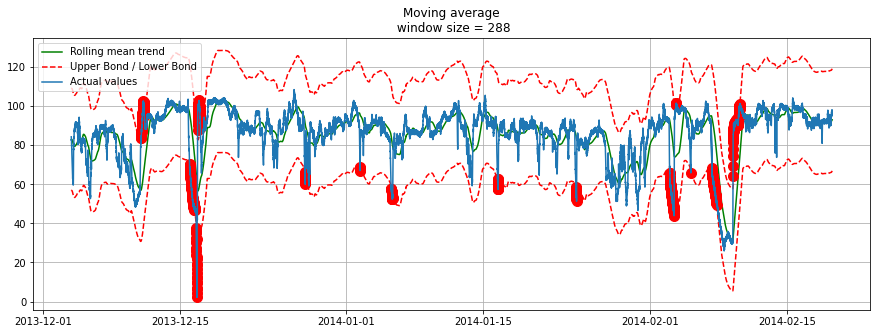

In [ ]:
plotMovingAverage(temp_df, int(24*60/5), plot_intervals=True, plot_anomalies=True) # daily trend

In [28]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
from scipy.optimize import minimize   

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [29]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [30]:
%%time
data = temp_df.value[:-int(temp_df.shape[0]*0.2)] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.001756415622237828 0.0008467956854847913 0.0003396389347350426
CPU times: user 1min 2s, sys: 93.5 ms, total: 1min 2s
Wall time: 1min 2s


In [31]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13)

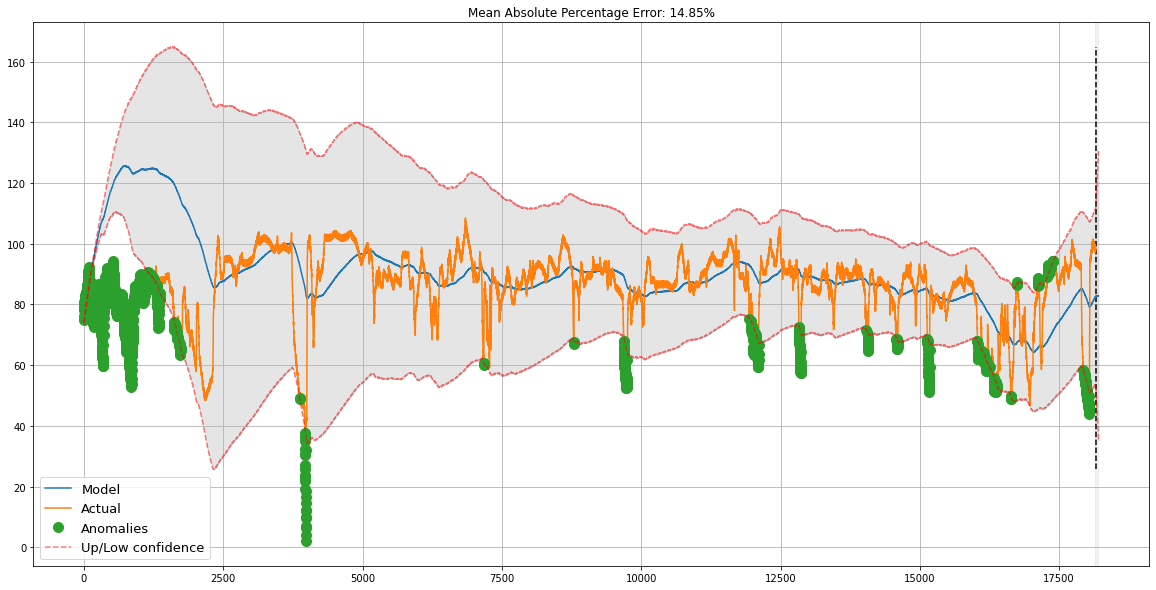

In [34]:
plotHoltWinters(temp_df.value[:int(temp_df.shape[0]-int(temp_df.shape[0]*0.2))], plot_intervals=True, plot_anomalies=True)

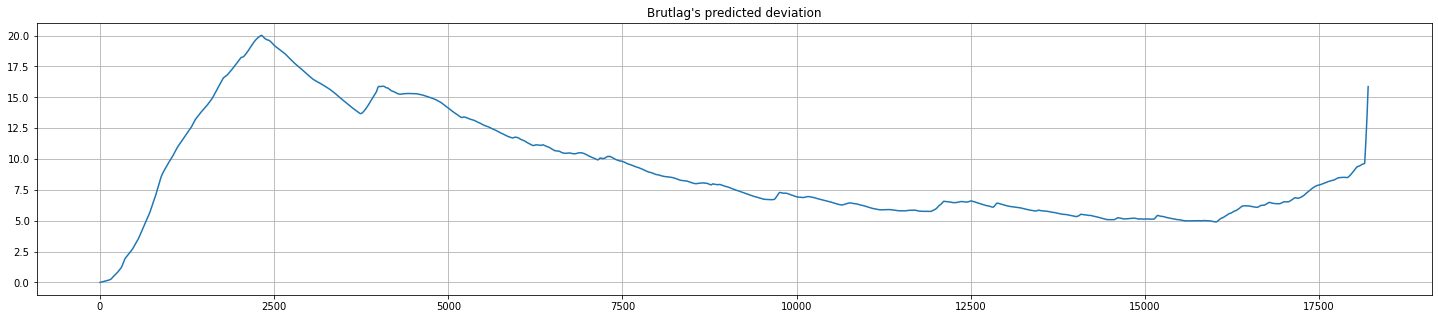

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
# 24 * 60 / 5 = 288 timesteps per day
# 22695 data points in total
train_df = temp_df[:int(temp_df.shape[0]*0.8)]
test_df = temp_df[-int(temp_df.shape[0]-int(temp_df.shape[0]*0.8)):]

In [5]:
print(temp_df.shape)
print(train_df.shape)
print(test_df.shape)
assert(temp_df.shape[0] == train_df.shape[0] + test_df.shape[0])

(22695, 1)
(18156, 1)
(4539, 1)


In [6]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = train_df.mean()
training_std = train_df.std()
df_training_value = (train_df - training_mean) / training_std

In [7]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (17868, 288, 1)


In [10]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [11]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
126/126 [==============================] - 34s 9ms/step - loss: 0.2736 - val_loss: 0.0300
Epoch 2/50
126/126 [==============================] - 1s 4ms/step - loss: 0.0200 - val_loss: 0.0177
Epoch 3/50
126/126 [==============================] - 1s 4ms/step - loss: 0.0124 - val_loss: 0.0211
Epoch 4/50
126/126 [==============================] - 1s 4ms/step - loss: 0.0098 - val_loss: 0.0367
Epoch 5/50
126/126 [==============================] - 1s 4ms/step - loss: 0.0083 - val_loss: 0.0547
Epoch 6/50
126/126 [==============================] - 1s 4ms/step - loss: 0.0077 - val_loss: 0.0670
Epoch 7/50
126/126 [==============================] - 1s 4ms/step - loss: 0.0071 - val_loss: 0.0798


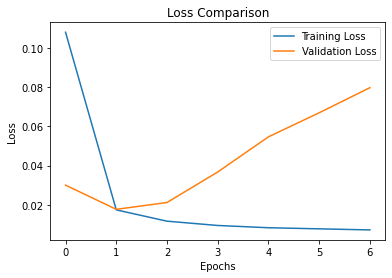

In [22]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Comparison")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

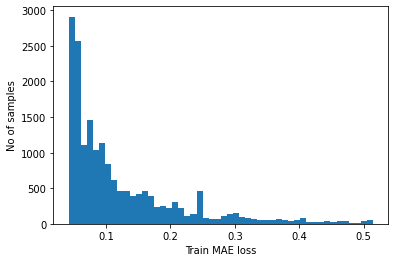

Reconstruction error threshold:  0.5144187943492795


In [13]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


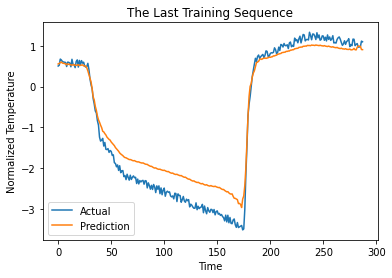

In [20]:
# Checking how the last sequence is learnt
plt.plot(x_train[-1], label="Actual")
plt.plot(x_train_pred[-1], label="Prediction")
plt.title("The Last Training Sequence")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Normalized Temperature")
plt.show()

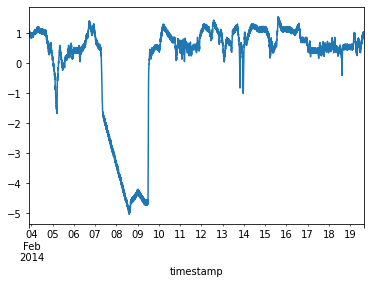

Test input shape:  (4251, 288, 1)


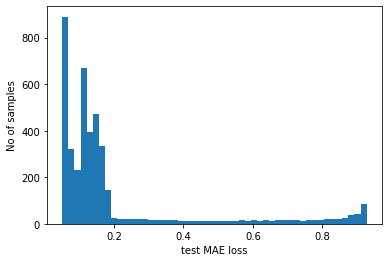

Number of anomaly samples:  493
Indices of anomaly samples:  (array([ 969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
        980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
        991,  992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001,
       1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,
       1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
       1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045,
       1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056,
       1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067,
       1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078,
       1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089,
       1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100,
       1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1

In [14]:
df_test_value = (test_df - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [15]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

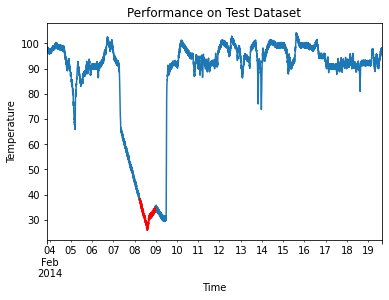

In [23]:
df_subset = test_df.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
test_df.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.title("Performance on Test Dataset")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.show()

In [ ]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed


df = pd.read_csv("/content/drive/MyDrive/Dogus Tech Interview/machine_temperature_system_failure.csv")
df = df[['timestamp', 'value']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'].min(), df['timestamp'].max()

(Timestamp('2013-12-02 21:15:00'), Timestamp('2014-02-19 15:25:00'))

In [ ]:
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [ ]:
df.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  22695 non-null  datetime64[ns]
 1   value      22695 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 354.7 KB


In [ ]:
train, test = df.loc[df['timestamp'] <= '2014-02-01'], df.loc[df['timestamp'] > '2014-02-01']
train.shape, test.shape

((17326, 2), (5369, 2))

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
TIME_STEPS=288

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['value']], train['value'])
X_test, y_test = create_sequences(test[['value']], test['value'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (17038, 288, 1)
Testing shape: (5081, 288, 1)


In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 288, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 288, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 288, 128)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 288, 1)            129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
480/480 [==============================] - 323s 664ms/step - loss: 0.1877 - val_loss: 0.1056
Epoch 2/100
480/480 [==============================] - 325s 676ms/step - loss: 0.1110 - val_loss: 0.0971
Epoch 3/100
480/480 [==============================] - 324s 676ms/step - loss: 0.1006 - val_loss: 0.0781
Epoch 4/100
480/480 [==============================] - 320s 667ms/step - loss: 0.1022 - val_loss: 0.1029
Epoch 5/100
480/480 [==============================] - 321s 669ms/step - loss: 0.0963 - val_loss: 0.1163
Epoch 6/100
480/480 [==============================] - 323s 672ms/step - loss: 0.0920 - val_loss: 0.1295


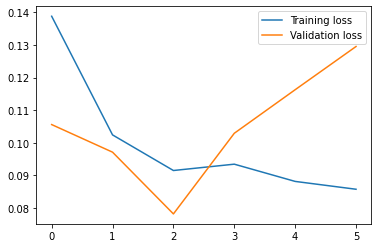

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

159/159 [==============================] - 28s 177ms/step - loss: 0.1594


0.15943248569965363

Reconstruction error threshold: 3.767034804824206


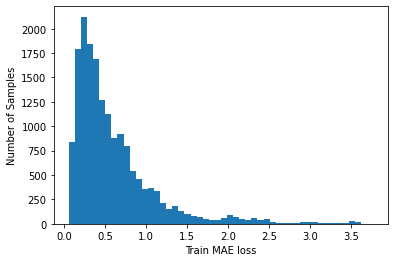

In [ ]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

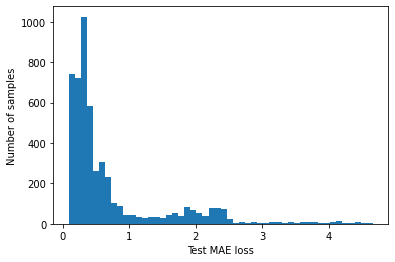

In [ ]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [ ]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['value'] = test[TIME_STEPS:]['value']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [ ]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(70, 5)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=scaler.inverse_transform(test_score_df['value']), name='Temperature'))
fig.add_trace(go.Scatter(x=anomalies['timestamp'], y=scaler.inverse_transform(anomalies['value']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()